In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import plotly.express as px
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
import warnings

warnings.filterwarnings('ignore')


page = "https://kamernet.nl/en/for-rent/rooms-utrecht?pageno=1"
page = requests.get(page).text
page_parse = BeautifulSoup(page,"html.parser")


In [3]:
classes = ["tile-title truncate","tile-city","tile-room-type","tile-rent",
"tile-surface","tile-furnished","tile-availability"]
item_prop = ['latitude','longitude']
details = ['living_room','kitchen','shower','toilet','internet','energy_label','pets']

data_dict = {}
details_dict = {}
for i in classes:
    data_dict[i] = []
for i in item_prop:
    data_dict[i] = []
for i in details:
    details_dict[i] = []
room_list =  []

In [4]:
most_popular_cities = set()
for i in page_parse:
    cities = page_parse.find_all(class_="most-searched-city-item thin")
    for city in cities:
        most_popular_cities.add(city.text)

In [5]:
other_popular_cities = ['Almere','Haarlem','Zaanstad','Amersfoort','Apeldoorn','Hoofddorp','Dordrecht','Zoetermeer','Zwolle']
for i in other_popular_cities:
    most_popular_cities.add(i)

In [6]:
for city in most_popular_cities:
    for i in range(1,8): #8 is magic
        page = f"https://kamernet.nl/en/for-rent/rooms-{city}?pageno={i}"
        page = requests.get(page).text
        page_parse = BeautifulSoup(page,"html.parser")
        for i in classes:
            information = page_parse.find_all(class_=i)
            for info in information:
                data_dict[i].append(info.text.strip())
                try:
                    if info['href']:
                        room_list.append(info['href'])
                    else:
                        room_list.append('not found')
                except:
                    pass
        for j in item_prop:
            geo_info = page_parse.find_all(itemprop = j)
            for geo in geo_info:
                data_dict[j].append(geo['content'])


In [7]:
data = pd.DataFrame.from_dict(data_dict,orient="columns")
#data = pd.read_csv('data.csv')
new_names =["adress","city","room_type","rent","surface m2","furnish","availability"]
data.rename(columns={x:y for x,y in zip(data.columns,new_names)},inplace=True)

In [8]:
data.room_type = [x.split('-')[1] for x in data.room_type]

In [9]:
data["utilities"] = [x.split(",")[1] for x in data.rent]
data['rent'] = [x.split(",")[0].strip().split(" ")[1] for x in data.rent]
data['surface m2'] = [x.strip().split(" ")[0] for x in data["surface m2"]]
data['surface m2'] = [int(x) for x in data["surface m2"]]


In [10]:
data.rent = [int(x) for x in data.rent]

In [11]:
data["utilities"] = [x.strip() for x in data.utilities]
for i,j in enumerate(data.utilities):
    if j == "-":
        data.utilities.iloc[i] = "excluded"
    if j =="-  Utilities incl.":
        data.utilities.iloc[i] = "included"


In [12]:
data.replace('','unknown',inplace=True)

In [13]:
data['link'] = room_list


In [14]:
r = []
for i in data.link:
    page = str(i)
    page = requests.get(i).text
    page_parser = BeautifulSoup(page,"html.parser")
    rooms = page_parser.find_all(class_='rooms-numbers')
    details_all = page_parser.find_all(class_='text-poppins-bold')
    if rooms:
        for room in rooms:
            r.append(room.text)
    else:
        r.append('not found')

    for k,j in zip(details,details_all):
        details_dict[k].append(j.text.strip())
    


In [15]:
details_df = pd.DataFrame.from_dict(details_dict,orient="columns")
data = pd.concat([data,details_df],axis=1)

In [16]:
data['room'] = r

In [17]:
data.room = [x.strip() for x in data.room]
#data.room = [re.search(r'\d+', x) for x in data.room]
data.room = [x.split("    ")[0] for x in data.room]
data.room.replace("Total -1 rooms ",1,inplace=True)
data.room_type = [x.lstrip() for x in data.room_type]
for j,i in enumerate(data.room):
    for s in i.split():
        if s.isdigit():
            data.room.iloc[j] = int(s)
data.furnish = ['Unfurnished' if x == 'unknown' else x for x in data.furnish]
data.living_room = ["Unknown" if x not in ['Shared','Own'] else x for x in data.living_room]
data.kitchen = ["Unknown" if x == 'None' else x for x in data.kitchen]
data.shower = ["Unknown" if x == 'None' else x for x in data.shower]
data.toilet = ["Unknown" if x == 'None' else x for x in data.toilet]

In [18]:
for n,i in enumerate(data.room):
    if i == 'not found':
        if data['surface m2'][n] <= 18:
            data.room.iloc[n] = 1
        else:
            remainder = data['surface m2'][n] // 18
            data.room.iloc[n] = int(remainder) 

Distribution of Rent prices in the most Popular cities.

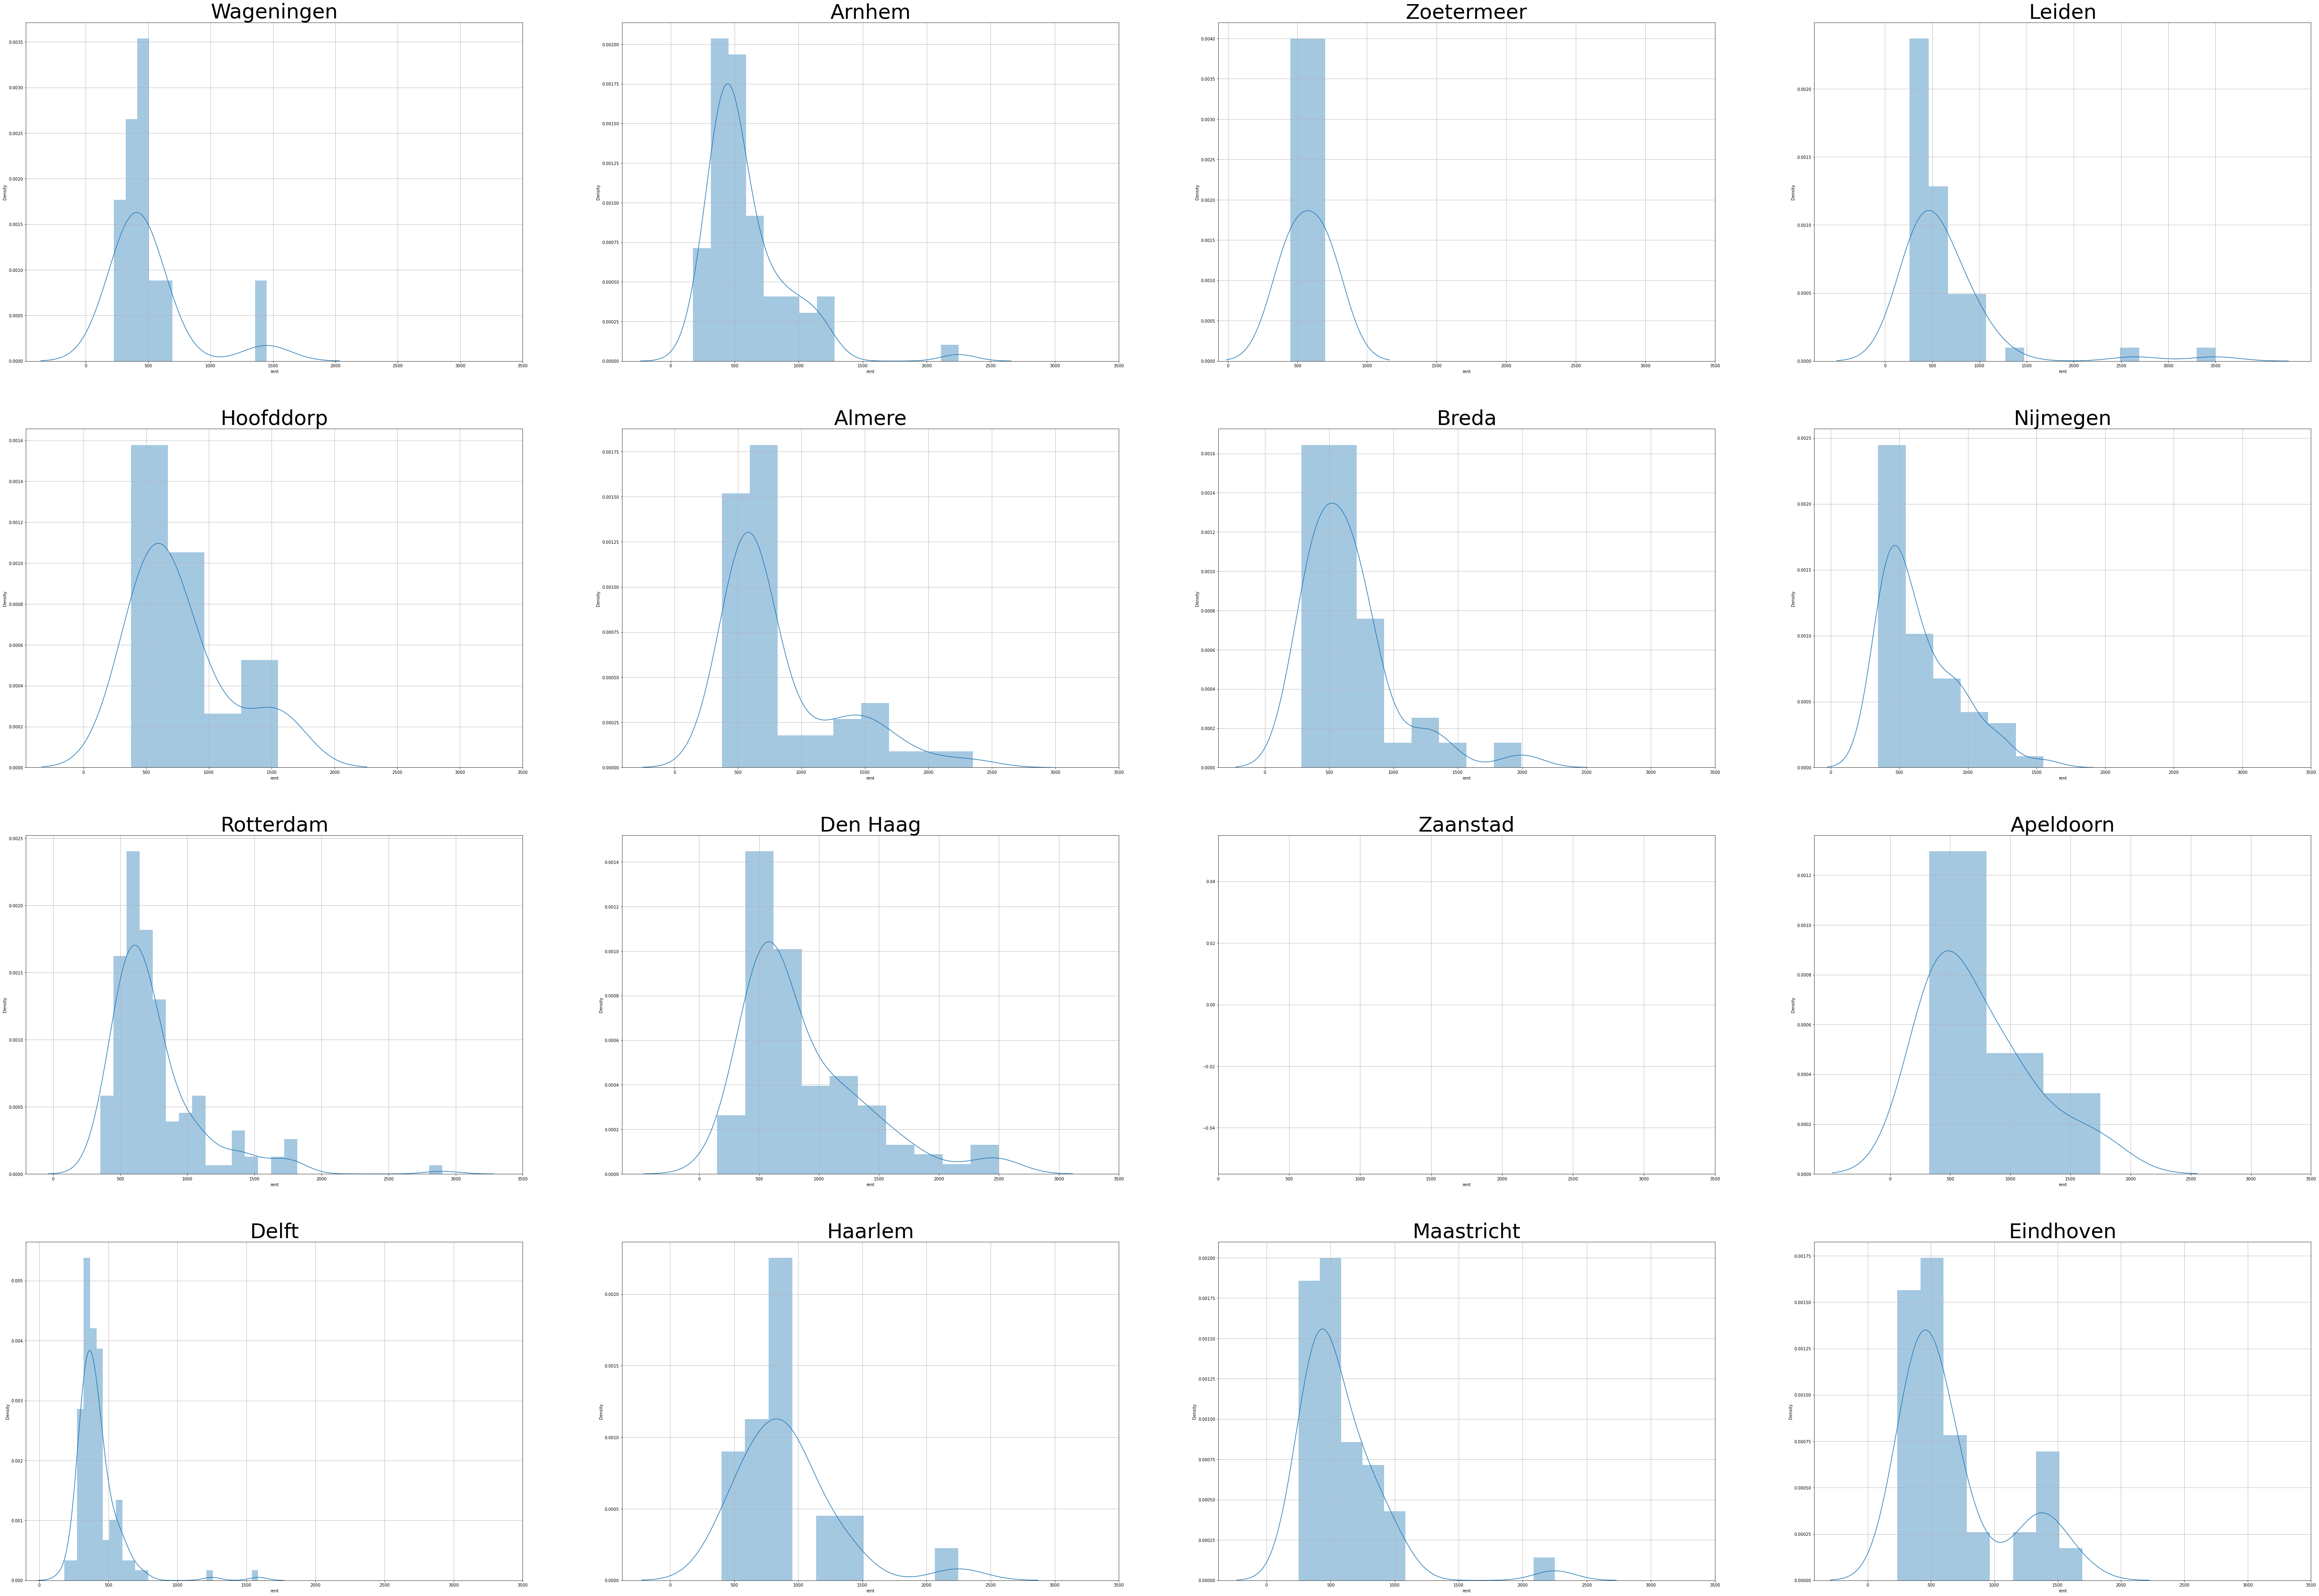

In [19]:
fig ,axs = plt.subplots(4,4,figsize=(100,70))
most_popular_cities = list(most_popular_cities)
for i,ax in zip(range(len(most_popular_cities)),axs.flat):
    plt.title(most_popular_cities[i])
    sns.distplot(data[data.city == most_popular_cities[i]]['rent'],ax=ax)
    ax.set_xticks(range(0,4000,500))
    ax.set_title(most_popular_cities[i],fontsize=50)
    ax.grid(True)


Distribution of Surface space in the most popular cities.

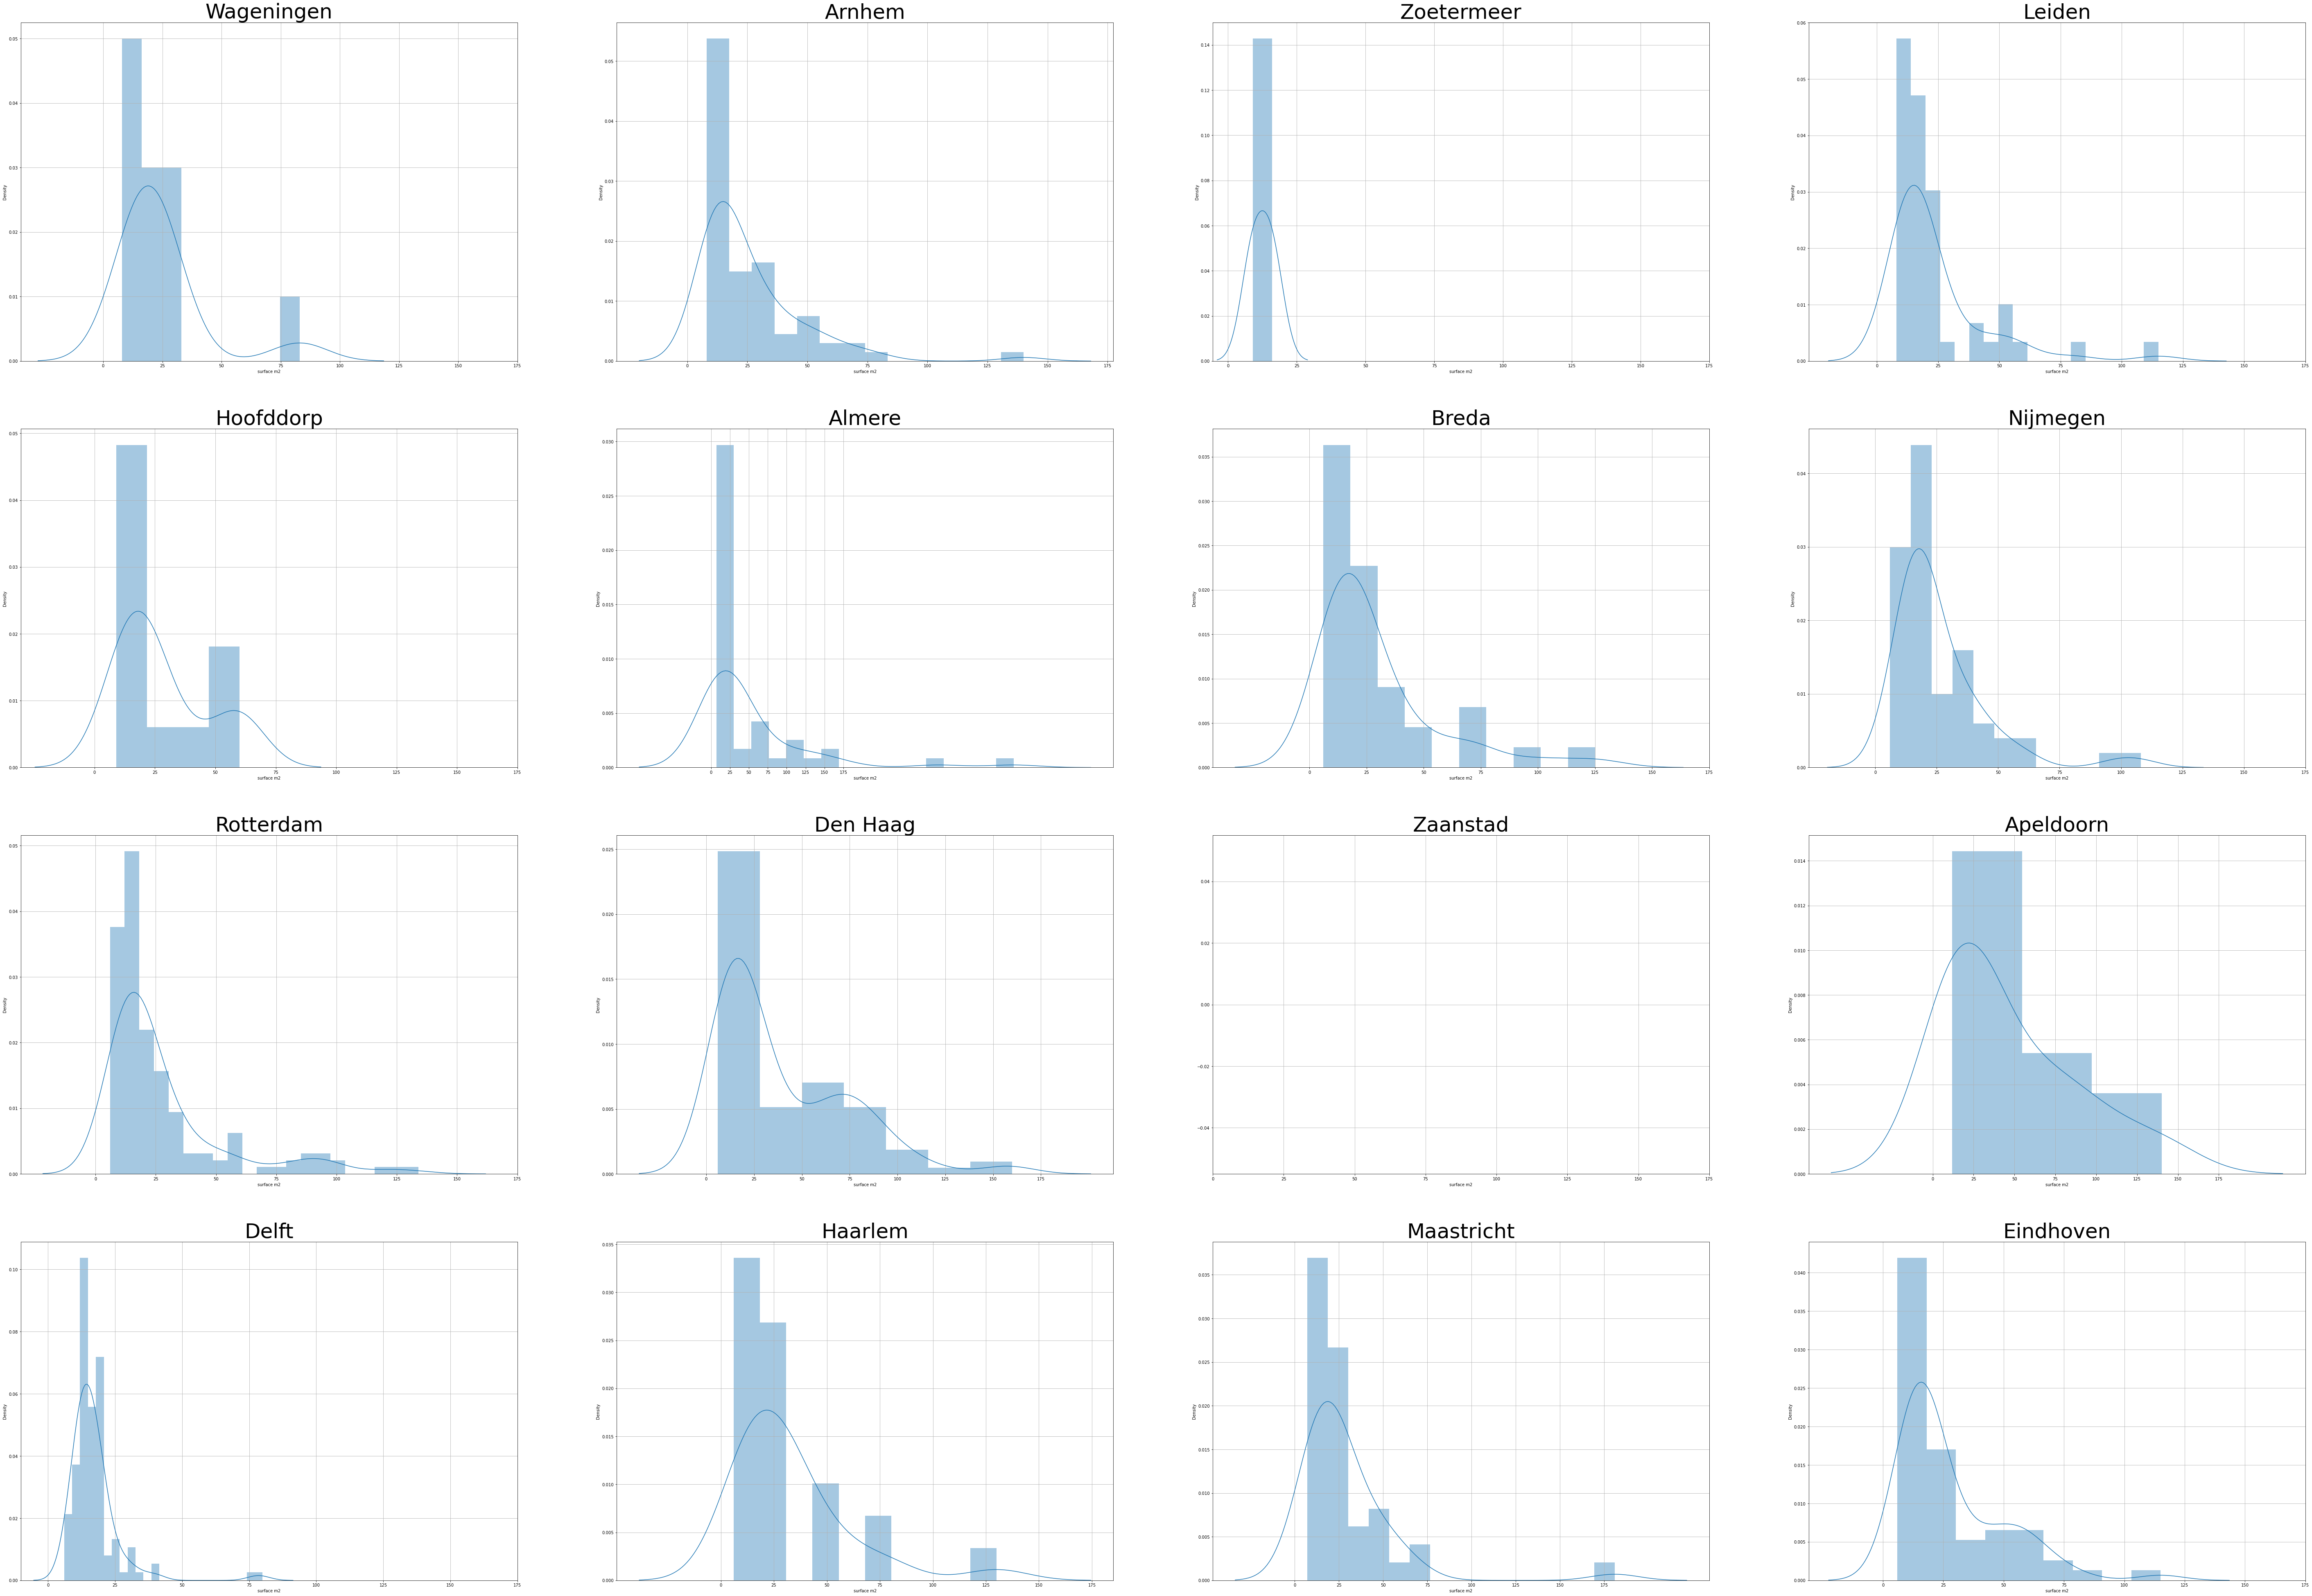

In [20]:
fig ,axs = plt.subplots(4,4,figsize=(100,70))
most_popular_cities = list(most_popular_cities)
for i,ax in zip(range(len(most_popular_cities)),axs.flat):
    plt.title(most_popular_cities[i])
    sns.distplot(data[data.city == most_popular_cities[i]]['surface m2'],ax=ax)
    ax.set_xticks(range(0,200,25))
    ax.set_title(most_popular_cities[i],fontsize=50)
    ax.grid(True)
    plt.grid(True)

Text(0.5, 0, 'Place')

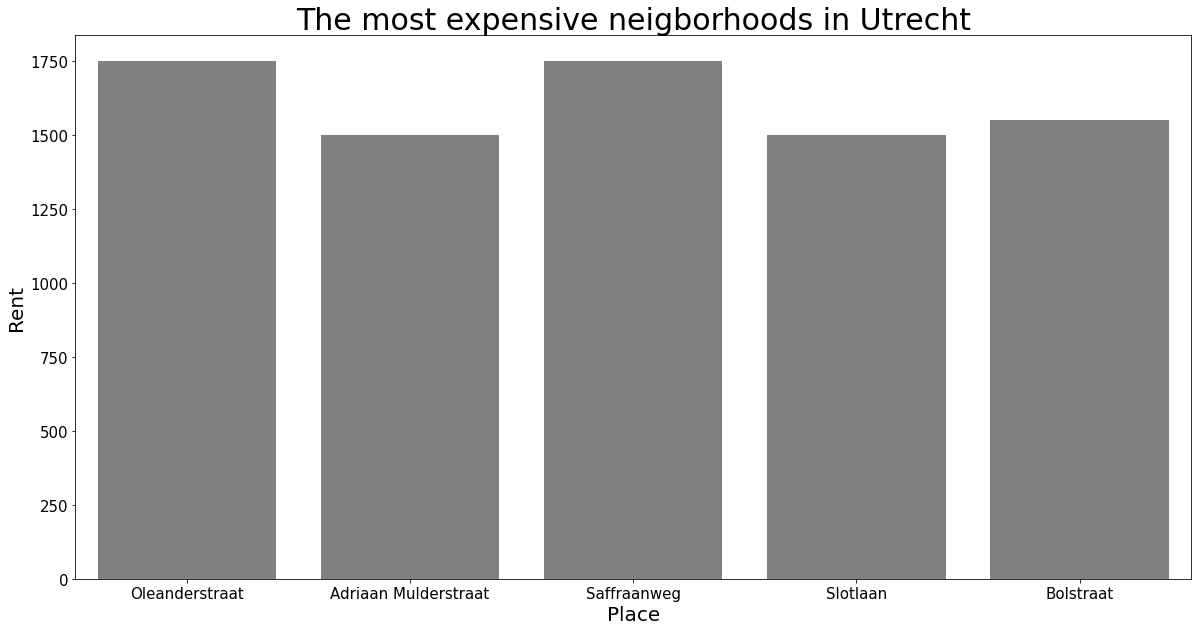

In [21]:
rent_dict = {}
rent_list = []
city = "Utrecht"

for i in data[data.city==city].adress.unique():
    rent_dict[i] = data[data.adress == i].rent.mean()

for i in range(5):
    max_value = max(rent_dict,key=rent_dict.get)
    rent_list.append(max_value)
    rent_dict.pop(max_value)

plt.figure(figsize=(20,10))
a = sns.barplot(data[data.adress.isin(rent_list)].adress,data[data.adress.isin(rent_list)].rent,
palette=['grey'])
a.tick_params(labelsize=15)
a.set_title(f'The most expensive neigborhoods in {city}',fontsize=30)
a.set_ylabel('Rent',fontsize=20)
a.set_xlabel('Place',fontsize=20)

Comparing rental prices based on Utilities. Interestingly rental prices higher in places where Utilities are excluded.

Text(0.5, 1.0, 'Rent Comparison between Utilities')

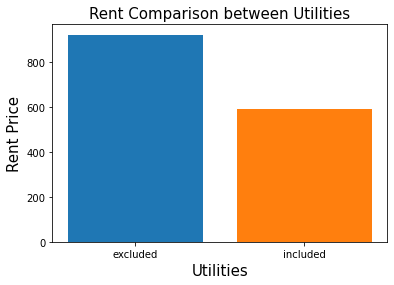

In [22]:
plt.bar(data[data.utilities=='excluded']['utilities'],data[data.utilities=='excluded']['rent'].mean())
plt.bar(data[data.utilities=='included']['utilities'],data[data.utilities=='included']['rent'].mean())
plt.xlabel('Utilities',fontsize=15)
plt.ylabel('Rent Price',fontsize=15)
plt.title('Rent Comparison between Utilities',fontsize=15)

Rental Price comparison based on the number of rooms. 

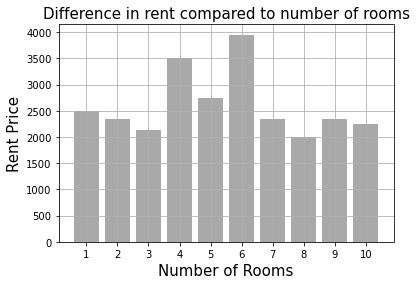

In [44]:
colors = ['darkgrey']
data_copy = data[data.room <= 10]
plt.bar(data_copy[data_copy.room !='not found']['room'],data_copy[data_copy.room!='not found']['rent'],color=colors)
plt.xticks(range(1,11))
plt.xlabel('Number of Rooms',fontsize=15)
plt.ylabel('Rent Price',fontsize=15)
plt.title('Difference in rent compared to number of rooms',fontsize=15)
plt.grid(True)


Showing relationship between surface area and rent prices in most popular cities.

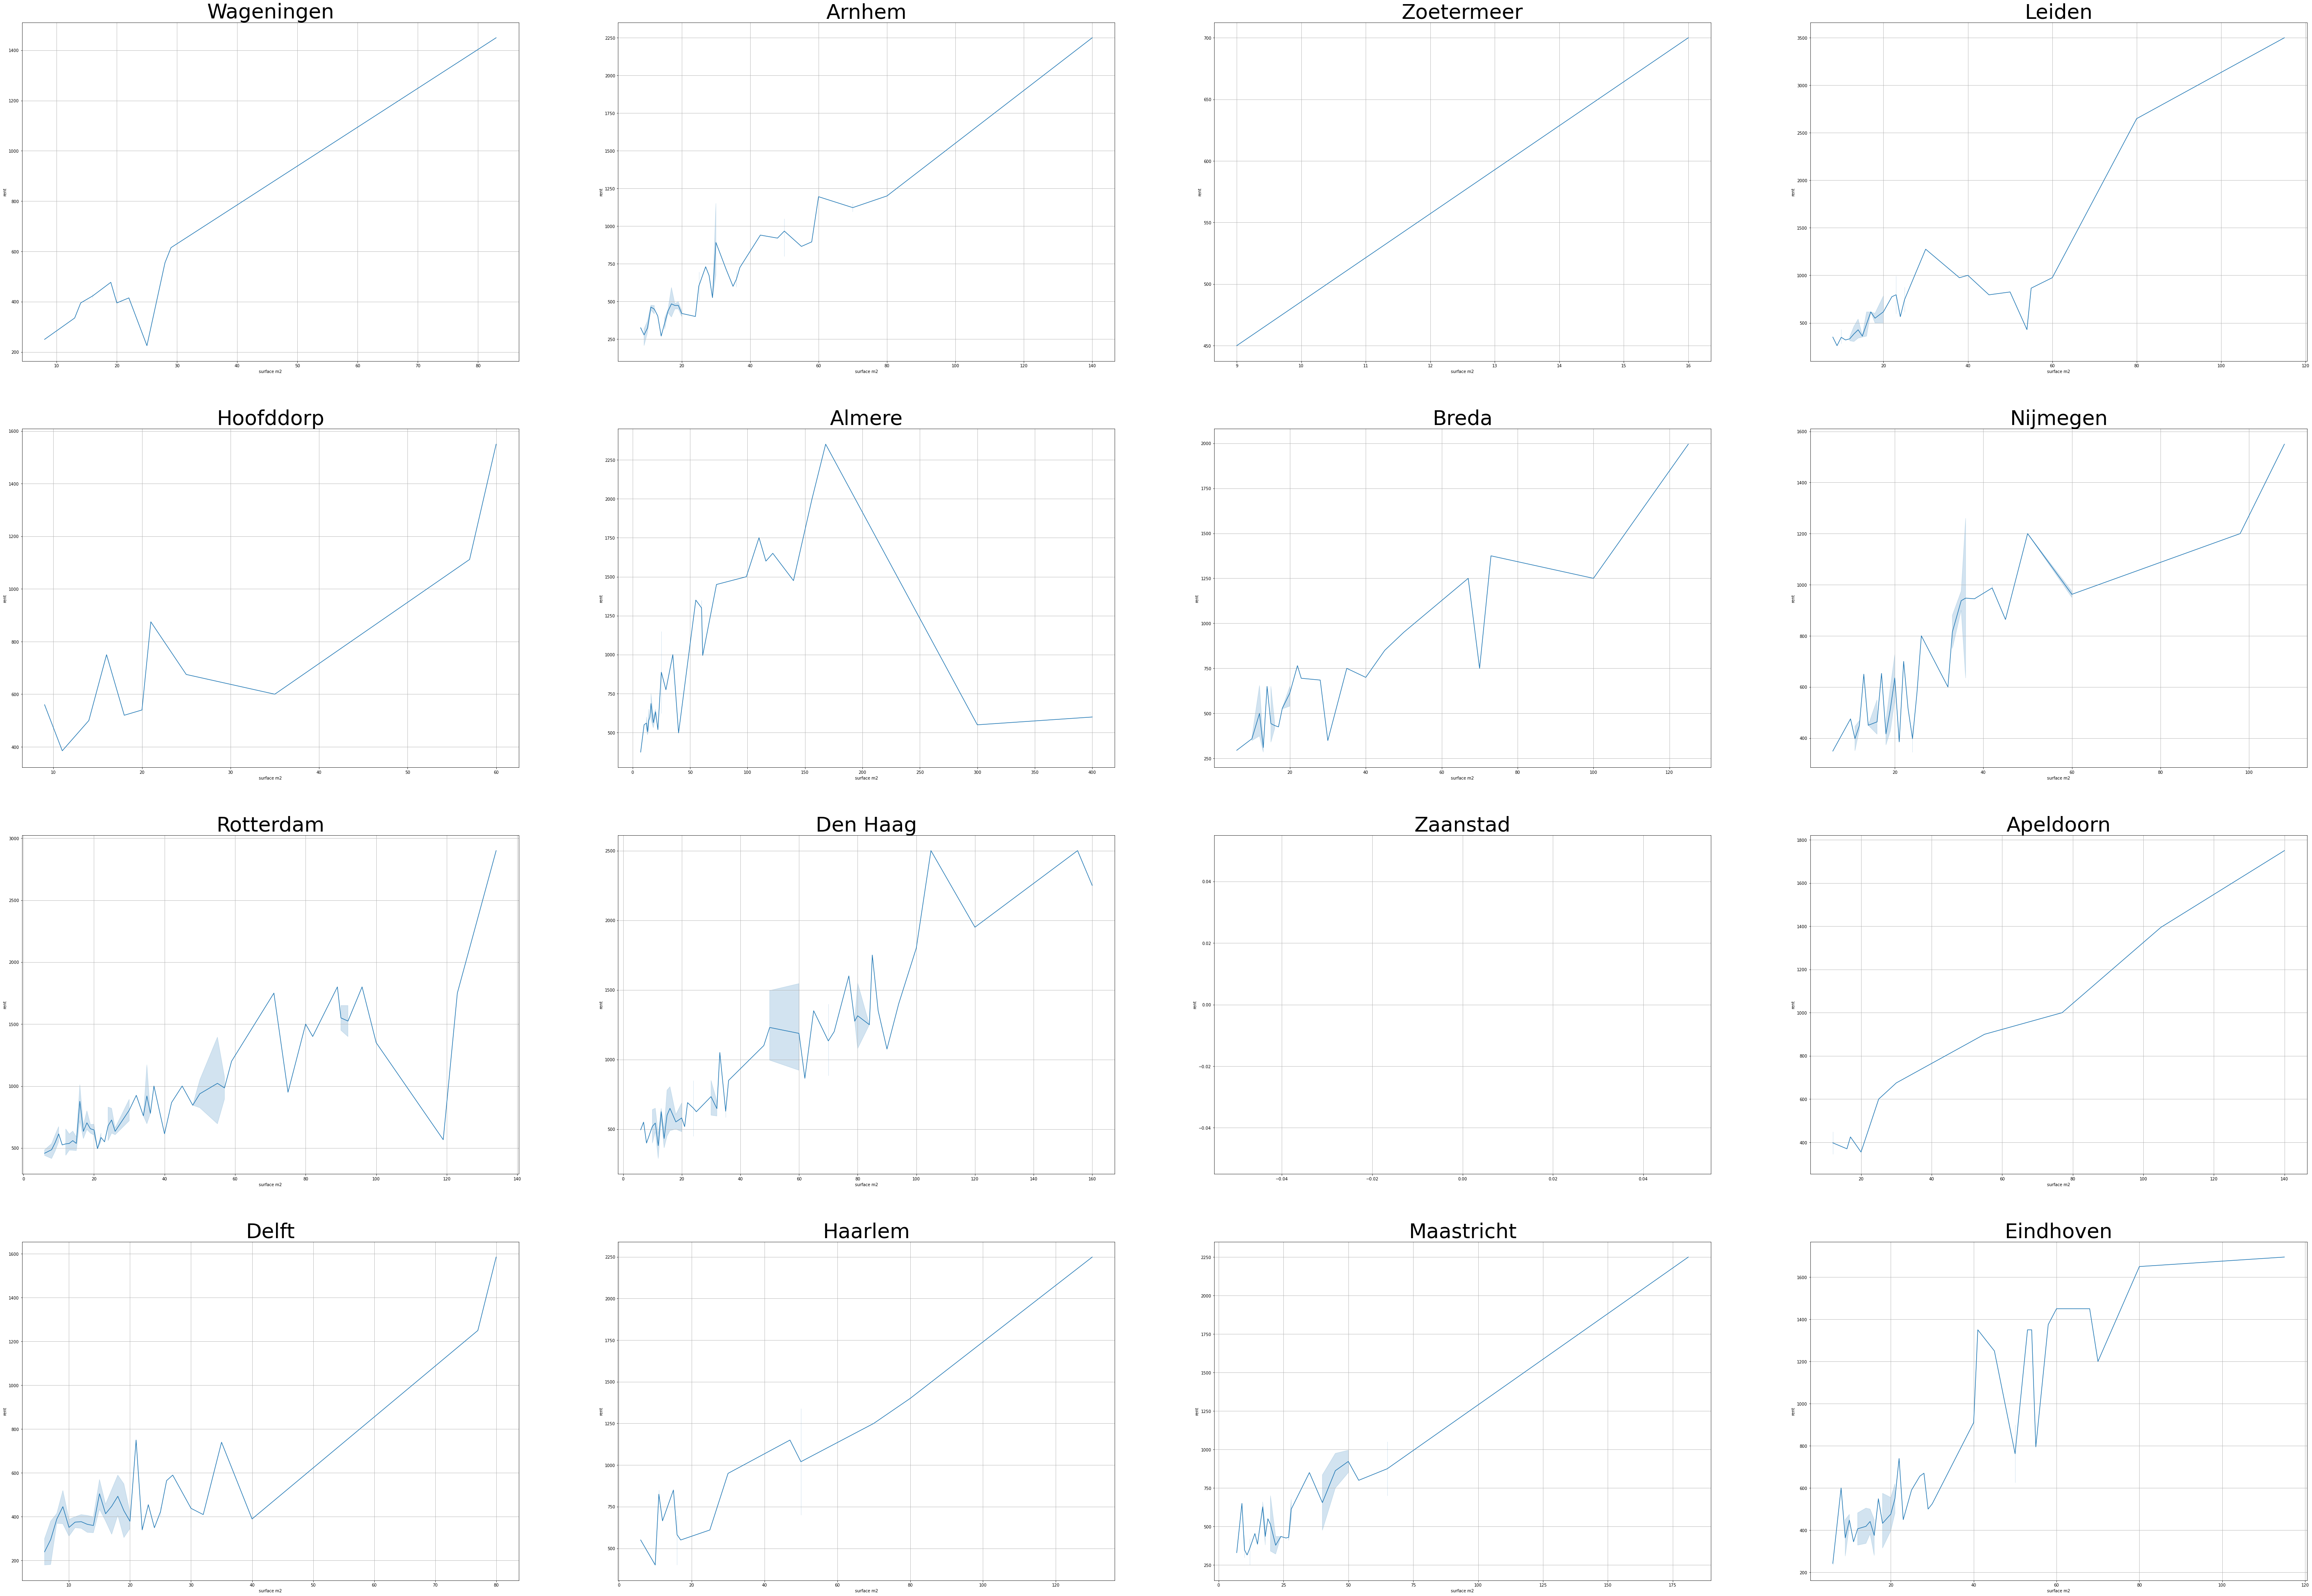

In [24]:
fig ,axs = plt.subplots(4,4,figsize=(100,70))
most_popular_cities = list(most_popular_cities)
for i,ax in zip(range(len(most_popular_cities)),axs.flat):
    plt.title(most_popular_cities[i])
    sns.lineplot(data[data.city == most_popular_cities[i]]['surface m2'].sort_values(ascending=True),data.rent,ax=ax)
    ax.set_title(most_popular_cities[i],fontsize=50)
    ax.grid(True)
    plt.grid(True)

Text(0.5, 1.0, 'Rent Comparison between room type')

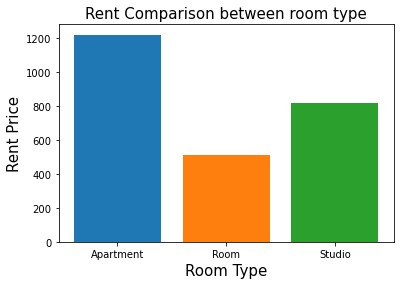

In [45]:
for i in data.room_type.unique():
    plt.bar(data[data.room_type==i]['room_type'],data[data.room_type==i]['rent'].mean())
plt.xlabel('Room Type',fontsize=15)
plt.ylabel('Rent Price',fontsize=15)
plt.title('Rent Comparison between room type',fontsize=15)


In [28]:
k = gpd.read_file('https://opendata.arcgis.com/datasets/620c2ab925f64ed5979d251ba7753b7f_0.geojson')

In [29]:
data.latitude = [float(x) for x in data.latitude]
data.longitude = [float(x) for x in data.longitude]

In [30]:
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
geo_data = GeoDataFrame(data,geometry=geometry)

Heatmap of where all the rental advertisements are located.

In [31]:
fig = px.density_mapbox(geo_data,lat='latitude',lon='longitude',hover_name='rent',color_continuous_scale= [
                [0.0, "green"],
                [0.5, "green"],
                [0.51111111, "yellow"],
                [0.71111111, "yellow"],
                [0.71111112, "red"],
                [1, "red"]],
                        opacity = 0.5,
                        mapbox_style='satellite',title='Housing Heatmap')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Scatter map of all the rental advertisements.

In [32]:
fig = px.scatter_mapbox(geo_data,lat='latitude',lon='longitude',hover_name='rent',color='rent',size='rent',
color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

with open('map.html','w') as m:
    m.write(fig.to_html())

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.linear_model import BayesianRidge


categorical_data = data[['adress','city','room_type','furnish','utilities']]
num_data = data[["surface m2",'room']]
dummies = pd.get_dummies(categorical_data)
preprocessed_data = pd.concat([dummies,num_data],axis=1)
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data,data.rent,test_size=0.2)


gb = GaussianNB()
linreg =  LinearRegression()
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()
boosting = GradientBoostingRegressor()
ada = AdaBoostRegressor()
bridge = BayesianRidge()
models = [linreg,gb,ridge,lasso,tree,forest,boosting,ada,bridge]
model_score = {}

for model in models:
    model.fit(X_train,y_train)
    model_score[model.__class__.__name__] = np.sqrt(mean_squared_error(y_test,model.predict(X_test)))
performance = pd.DataFrame([model_score])
performance

,LinearRegression,GaussianNB,Ridge,Lasso,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BayesianRidge
0,190.992948,305.572266,177.923975,184.615064,195.706237,179.646326,186.54896,245.420034,176.736637


In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

cat_list = ['adress','city','room_type','furnish','utilities','kitchen', 'shower',
'toilet', 'internet','energy_label']
categorical_data = data[['adress','city','room_type','furnish','utilities','kitchen', 'shower',
'toilet', 'internet','energy_label']]
cat_encoded = encoder.fit_transform(categorical_data).toarray()
cat_encoded = pd.DataFrame(cat_encoded,columns=encoder.get_feature_names())
preprocessed_data = pd.concat([cat_encoded,num_data],axis=1)

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data,data.rent,test_size=0.2)

models = [linreg,gb,ridge,lasso,tree,forest,boosting,ada,bridge]
model_score = {}

for model in models:
    model.fit(X_train,y_train)
    model_score[model.__class__.__name__] =  np.sqrt(mean_squared_error(y_test,model.predict(X_test)))
performance = pd.DataFrame([model_score])
performance

,LinearRegression,GaussianNB,Ridge,Lasso,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,Lars,BayesianRidge
0,5.525991e+11,291.863741,167.70038,181.265675,209.513945,173.243741,178.73289,229.392989,1.480703e+15,167.013093


Exporting best performed model(Ridge Regression).

In [ ]:
import pickle

pickle.dump(ridge,open('ridgemodel.sav','wb'))
model = pickle.load(open('ridgemodel.sav','rb'))

In [46]:
data.to_csv('data.csv')